In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd

from batchflow import Pipeline, B, V, I, M, C, plot
from batchflow.models.torch import TorchModel, VGGBlock
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from loader import ImagesDataset

In [3]:
SEED = 11
rng = np.random.default_rng(SEED)

In [4]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=SEED)

100%|█████████████████████████████████████████████| 9/9 [00:16<00:00,  1.87s/it]


In [5]:
MODEL_PATH = '../models/vgg.torch'
model = TorchModel()
model.load(MODEL_PATH)
penultimate_module = model.model[1][-2]

## 

In [6]:
%%time

predict_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)

    # initialize prediction and metrics containers
    .init_variables('images', 'labels', 'proba', 'predictions', 'metrics')
    
    # import trained model
    .import_model('model', model)
    
    # make predictions
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predictions', 'predicted_proba'], save_to=[B('predictions'), B('proba')])
    
    # get penultimate layer activations
    .call(model.get_intermediate_activations, inputs=B('images'),
          layers=penultimate_module, save_to=B('activations'))
)

predict_pipeline_train = predict_template << dataset.train
train_batch = predict_pipeline_train.next_batch(dataset.train.size)

CPU times: user 761 ms, sys: 1.05 s, total: 1.81 s
Wall time: 8.42 s


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


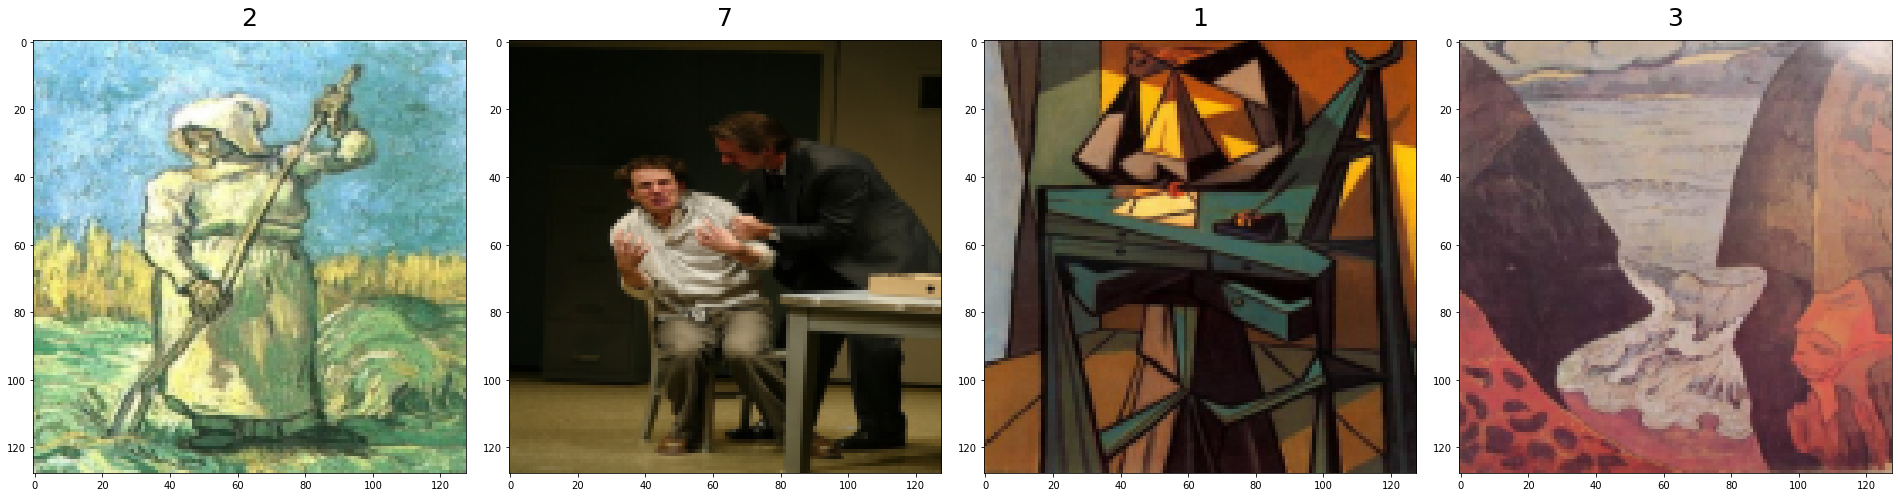

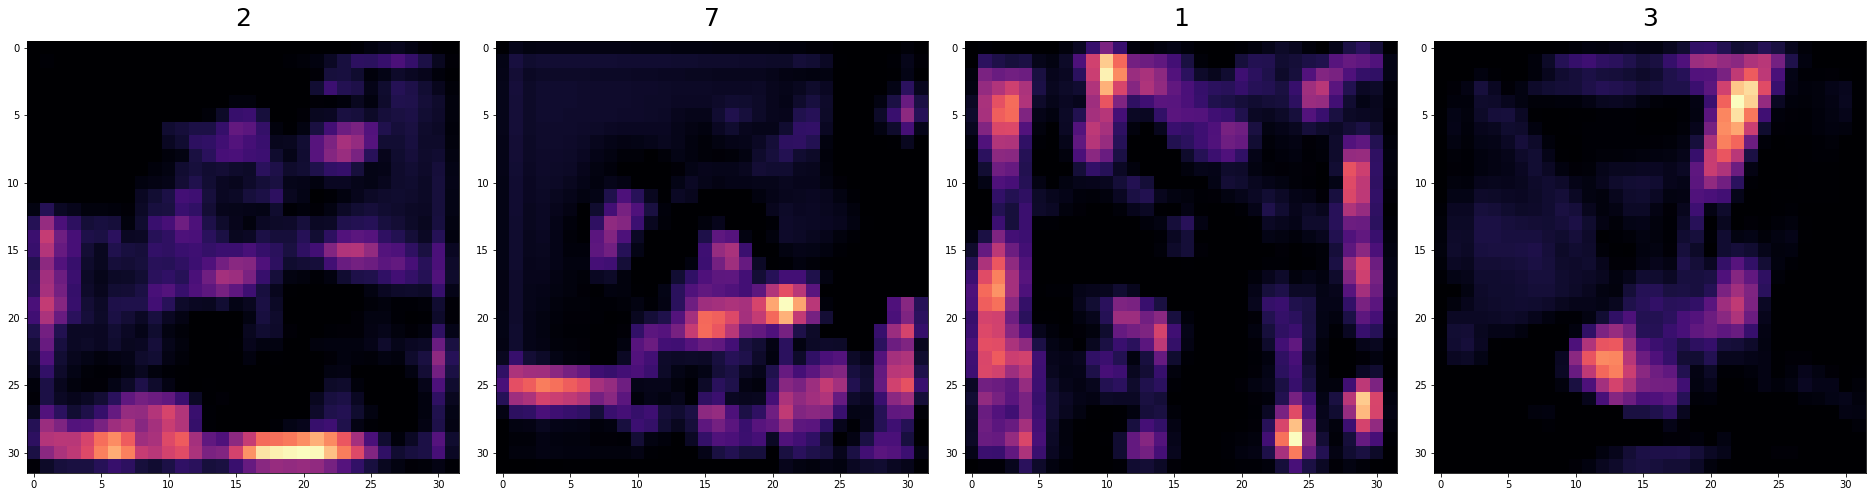

In [7]:
images = []
gradcams = []
labels = []

for index in rng.integers(0, dataset.train.size, 4):
    image = np.transpose(train_batch.images[index], (1, 2, 0))
    cam = model.get_gradcam(inputs=train_batch.images[index:index+1], layer=penultimate_module)
    images.append(image.reshape(*image.shape))
    gradcams.append(cam.reshape(*cam.shape, 1))
    label = train_batch.labels[index]
    labels.append(label)

plot(images, title=labels, combine='separate')
plot(gradcams, cmap='magma', title=labels, combine='separate')

In [29]:
%%time

n_features = 10
pca = PCA(n_components=n_features, random_state=SEED)
train_features = train_batch.activations.reshape(dataset.train.size, -1)
train_features_reduced = pca.fit_transform(train_features)

CPU times: user 1min 58s, sys: 1min 31s, total: 3min 29s
Wall time: 5.53 s


In [30]:
%%time

clusterer = KMeans(n_clusters=n_classes, random_state=SEED)
train_clustered = clusterer.fit_predict(train_features_reduced)

CPU times: user 771 ms, sys: 3.94 s, total: 4.71 s
Wall time: 71.3 ms


In [31]:
train_labels = train_batch.labels
train_predictions = np.argmax(train_batch.predictions, axis=1)

In [32]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [33]:
adjusted_rand_score(train_labels, train_predictions), adjusted_mutual_info_score(train_labels, train_predictions)

(1.0, 1.0000000000000002)

In [34]:
adjusted_rand_score(train_labels, train_clustered), adjusted_mutual_info_score(train_labels, train_clustered)

(1.0, 1.0000000000000002)

In [14]:
%%time

predict_pipeline_test = predict_template << dataset.test
test_batch = predict_pipeline_test.next_batch(dataset.test.size)

CPU times: user 148 ms, sys: 272 ms, total: 420 ms
Wall time: 2.08 s


In [35]:
%%time

test_features = test_batch.activations.reshape(dataset.test.size, -1)
test_features_reduced = pca.transform(test_features)

CPU times: user 1.31 s, sys: 827 ms, total: 2.14 s
Wall time: 389 ms


In [36]:
%%time

test_clustered = clusterer.predict(test_features_reduced)

CPU times: user 831 µs, sys: 828 µs, total: 1.66 ms
Wall time: 961 µs


In [37]:
test_labels = test_batch.labels
test_predictions = np.argmax(test_batch.predictions, axis=1)

In [38]:
adjusted_rand_score(test_labels, test_clustered), adjusted_mutual_info_score(test_labels, test_clustered)

(0.3965499998342777, 0.40228312838276054)

In [39]:
for i in range(n_classes):
    i_count = np.bincount(test_labels[test_clustered == i], minlength=n_classes)
    print(f"{i}: {i_count} | max: {np.argmax(i_count)}")

0: [ 0  3  5  0 30  1  1  0] | max: 4
1: [ 1  5 31  8  8  1  0  1] | max: 2
2: [ 2 56  7  6  1  0  3  2] | max: 1
3: [ 0  3  0  2  0  2  4 20] | max: 7
4: [ 0  1  2  2  5 14  0  3] | max: 5
5: [ 2  2  1 23  1  1  1  0] | max: 3
6: [1 1 0 0 0 0 8 1] | max: 6
7: [6 1 0 1 0 0 2 2] | max: 0


In [40]:
renumerate = {
    0: 4,
    1: 2,
    2: 1,
    3: 7,
    4: 5,
    5: 3,
    6: 6,
    7: 0,
}

renumerated = np.empty_like(test_clustered)
for old, new in renumerate.items():
    renumerated[test_clustered == old] = new

In [41]:
from batchflow.models.metrics import ClassificationMetrics

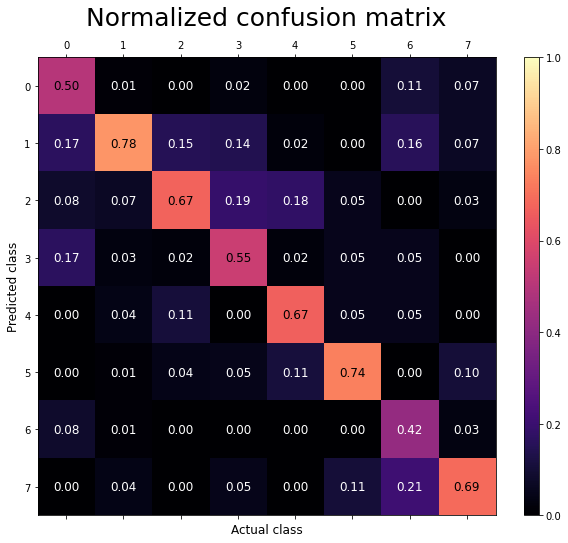

In [42]:
metrics = ClassificationMetrics(test_labels, renumerated, fmt='labels', num_classes=n_classes)
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [43]:
labels, counts = np.unique(dataset.labels[dataset.test.indices], return_counts=True)
shares = counts / counts.sum()

metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'counts': counts, 'shares': shares, **metrics_dict})

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=metrics_names)

,names,counts,shares,precision,recall
0,ArtDeco,12,0.042254,50%,50%
1,Cubism,72,0.253521,72%,77%
2,Impressionism,46,0.161972,56%,67%
3,Japonism,42,0.147887,74%,54%
4,Naturalism,45,0.158451,75%,66%
5,Rococo,19,0.066901,51%,73%
6,cartoon,19,0.066901,72%,42%
7,photo,29,0.102113,64%,68%


In [44]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,66%,63%


In [46]:
METRICS_PATH = '../metrics/knn_10.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
np.save(METRICS_PATH, all_metrics)

In [28]:
# labels = dataset.label_encoder.inverse_transform(batch.labels)
# for cluster_num in range(n_classes):
#     cluster_images = batch.images[clustered == cluster_num]
#     cluster_images = list(cluster_images.transpose(0, 2, 3, 1))
#     cluster_true_labels = labels[clustered == cluster_num].tolist()
#     plot(cluster_images, title=cluster_true_labels, suptitle=f"cluster: {cluster_num}", suptitle_y=1, suptitle_size=30, combine='separate')